# Project: Analyzing A/B test result: A case study to help company decide whether to launch a new homepage design
    
--By Lu Tang

In this project, we will do data analysis to help our client decide whether to launch two new features on their website. 

Here's the customer funnel for typical new users on their site:

**View home page > Explore courses > View course overview page > Enroll in course > Complete course**

Our client loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, Our client is performing **A/B tests** to try out changes that will hopefully increase conversion rates from one stage to the next.

A/B tests are used to test changes on a web page by running an experiment where a **control group** sees the old version, while the **experiment group** sees the new version. A **metric** is then chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:
>- **Null Hypothesis**: The new version is no better, or even worse, than the old version
>- **Alternative Hypothesis**: The new version is better than the old version

If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.

## Feature Changes: Change homepage design. 
Our client hopes that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

**Metric: Click through rate (CTR)**

Click through rate (CTR) is often defined as the the number of clicks divided by the number of views. Since our client uses cookies, we can identify unique users and make sure we don't count the same one multiple times. For this experiment, we'll define our click through rate as:

CTR: # clicks by *unique* users / # views by *unique* users

H0: CTR_{new} - CTR_{old} <= 0

H1: CTR_{new} - CTR_{old} > 0 

**The company has collected the data in homepage_actions.csv, we will use Python to analyze the data**

In [1]:
# load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# to make sure we get the same results everytime we run the code
np.random.seed(42)

In [2]:
# load the data and display first 5 rows
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [3]:
# total number of actions
df.shape

(8188, 4)

- The total number of actions is 8188

In [4]:
# number of unique users
df.nunique()

timestamp    8188
id           6328
group           2
action          2
dtype: int64

- The number of unique users is 6328

In [5]:
# number of control and experiement group in this dataset (total number, not unique unser)
df['group'].value_counts()

control       4264
experiment    3924
Name: group, dtype: int64

In [6]:
# sizes of the control and experiment groups (i.e., the number of unique users in each group)
df.groupby('group')['id'].nunique()

group
control       3332
experiment    2996
Name: id, dtype: int64

- The number of unique users in control group is 3332
- The number of unique users in experiment group is 2996

### 2. How long was the experiment run for? 

In [7]:
# duration of this experiment
df.timestamp.min(), df.timestamp.max()

('2016-09-24 17:42:27.839496', '2017-01-18 10:24:08.629327')

- This experiment has run for 4 months

### 3. What action types are recorded in this dataset?

In [8]:
# action types in this experiment
df['action'].unique()

array(['view', 'click'], dtype=object)

- The action types are view and click

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

- The control and experiement group would have different number of total visitors
- More total click would occur in one version, even if there is a greater percentage of clicks in other version
- Getting the proportion of the users who click is more effective than getting the number of users who click when comparing groups of different sizes.

## The steps we took to analyze the results of this A/B test

Our Hypothesis for this test:

H0: CTR_{experiment} - CTR_{control} <= 0

H1: CTR_{experiment} - CTR_{control} > 0 

### Step_1. Compute the observed difference between the metric, CTR (click through rate), for the control and experiment group.

In [9]:
# experiment group data
experiment_df = df.query('group == "experiment"')

# CTR for experiment group
experiment_ctr = experiment_df.query('action=="click"')['id'].nunique()/experiment_df.query('action=="view"')['id'].nunique()

print(f'The CTR for experiment group is {experiment_ctr}')

The CTR for experiment group is 0.3097463284379172


In [10]:
# control group data
control_df = df.query('group == "control"')

# CTR for control group
control_ctr = control_df.query('action=="click"')['id'].nunique()/control_df.query('action=="view"')['id'].nunique()

print(f'The CTR for control group is {control_ctr}')

The CTR for control group is 0.2797118847539016


In [11]:
# observed difference
obs_diff = experiment_ctr - control_ctr
print(f'The observed difference in CTR betweent experiment group and control group is {obs_diff}')

The observed difference in CTR betweent experiment group and control group is 0.030034443684015644


- In this sample, the experiment group click through rate is higher than control group's click through rate by about 0.03. We then need to test if this difference is statistically significance and not due by random chance. Let's bootstrap the sample to simulate the sampling distribution for the difference in proportions

### Step_2. Use Bootstrapping technique to simulate the sampling distribution for the difference in proportions

In [12]:
# create an empty list for the differences in click through rates between experiment and control group 
diffs = []
# set sample size as the data size
size = df.shape[0]
for i in range(10000):
    # use bootstrap technique to take sample from a group with replacement
    # this is to simulate the creation of sampling distribution
    boots_sample = df.sample(size, replace = True)
    # the experiment group
    experiement_df = boots_sample.query('group == "experiment"')
    # get the control group 
    control_df = boots_sample.query('group == "control"')
    # calculate the ctr in experiment group
    experiment_ctr = experiment_df.query('action=="click"')['id'].nunique()/experiment_df.query('action=="view"')['id'].nunique()
    # calculate the ctr in control group
    control_ctr = control_df.query('action=="click"')['id'].nunique()/control_df.query('action=="view"')['id'].nunique()
    # calculatet the differences nd append all the number to diffs list
    diffs.append(experiment_ctr - control_ctr)

- By bootstrapping and then calculating repeated values of our statistics (experiment_ctr - control_ctr), we can gain an understanding of the sampling distribution of our statistics

In [13]:
# convert diffs list to numpy arrays
diffs = np.array(diffs)

Text(0, 0.5, 'frequency')

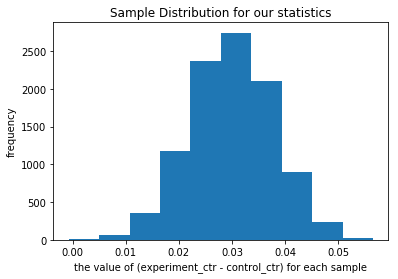

In [14]:
# visualize the sample distribution for the differences in click through rates between experiment and control group¶
plt.hist(diffs)
plt.title('Sample Distribution for our statistics')
plt.xlabel('the value of (experiment_ctr - control_ctr) for each sample')
plt.ylabel('frequency')

- From the histogram of the sample distribution, we can see the majority of our statistics is centered around 0.03. 

### Step_3. Use this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.

In [15]:
# simulate distribution under the null hypothesis
# nomal(loc=0.0, scale=diffs.std(), size=100000)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

Text(0, 0.5, 'frequency')

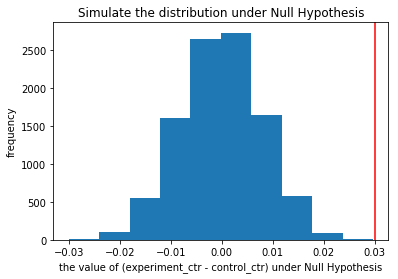

In [16]:
# plot the null distribution
plt.hist(null_vals)
# plot the observed statistic with the null distribution
plt.axvline(obs_diff, c = 'red')
plt.title('Simulate the distribution under Null Hypothesis')
plt.xlabel('the value of (experiment_ctr - control_ctr) under Null Hypothesis')
plt.ylabel('frequency')

- Our null hypothesis assume CTR_{experiment} - CTR_{control} <= 0, thus we simulate the null hypothesis distribution centered at zero, with the same standard deviation and same size as our sampling distribution. As we can see our observed difference (the red line) falls far to the right; it seems unlikely that our statistic is from this null. To prove our conclusio, we need to calculate the p-value, i.e. the probability of our observed statistic came from this null distribution

### Step_4. Compute the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.

In [17]:
# compute the p-value
p_value = (null_vals > obs_diff).mean()
print(f'The p-value is {p_value}')

The p-value is 0.0


### Step_5. Use this p-value to determine the statistical significance of our observed difference.

**Conclusion**
- We set p-value threshhold as 0.05, our calculated p-value is close to 0, which is less than our threshhold, thus we can conclude that our observed difference is statistically significant and we can reject null hypothesis.
- We can recommend to change the design of homepage to the new version.

## Summary of our steps and result:

First we set hypothesis, and our null hypothesis is H0: CTR_{experiment} - CTR_{control} <= 0.

In Step_1, we have calculated the observed difference in CTR between experiment and control group as **obs_diff**, i.e. CTR_{experiment} - CTR_{control} = 0.030034443684015644. 

We can not make conclusion to say the click through rate in experiment group is higher than the click through rate in control group by this one number (the observed difference) calculated by our collected data, because only judging from one sample, the result might be by random chance. We need to run statistical test to see if this number is statistically significant in order to reject our null hypothesis. 

With limited time and resources, we can not collect the same size of data 10000 times, thus We use bootstrapping technique to take sample from the a group (our sample data) with replacement 10000 times; this is to simulate the creation of sampling distribution for our statistics. 

From the histogram of the sample distribution, we can see the majority of the number is centered around 0.03. Since our null hypothesis is CTR_{experiment} - CTR_{control} <= 0, we need to create a normal distribution centered at 0, with the same standard deviation as our sampling distribution we simulated here; this is to simulate the null. 

We then calculate the p-value for our statistics, which is the observed difference in proportion by simulating the distribution under null hypothesis and then finding the probability that our statistic came from this distribution.

With p-value under 0.05, the difference in click through rates for the control and expriment group does appear to be significant, i.e. it seems unlikely that our statistic is from this null. Thus we can reject null hypothesis, and based on these results, we can give recommendation that our company should launch the new homepage design.